In [340]:
import torchvision
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

### 1. Data Preparation 

In [446]:
# PARAMS
IM_HEIGHT = 128
IM_WIDTH = 128
BATCH_SIZE = 128

In [447]:
# tranformation applied to each image (augmentation)
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.CenterCrop(IM_HEIGHT),
#     torchvision.transforms.RandomRotation(degrees=60),
#     torchvision.transforms.RandomVerticalFlip(),
#     torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
])

In [448]:
# download the data 
train = torchvision.datasets.CelebA(
    root="./data/",
    transform=data_transform,
    split="valid",
    download=True
)

Files already downloaded and verified


In [449]:
# create train_loader
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=BATCH_SIZE, shuffle=True)

In [450]:
print(x[6].shape, y.shape)

torch.Size([1, 128, 128]) torch.Size([16, 40])


In [451]:
len(train_loader)

156

##### Visualize Samples

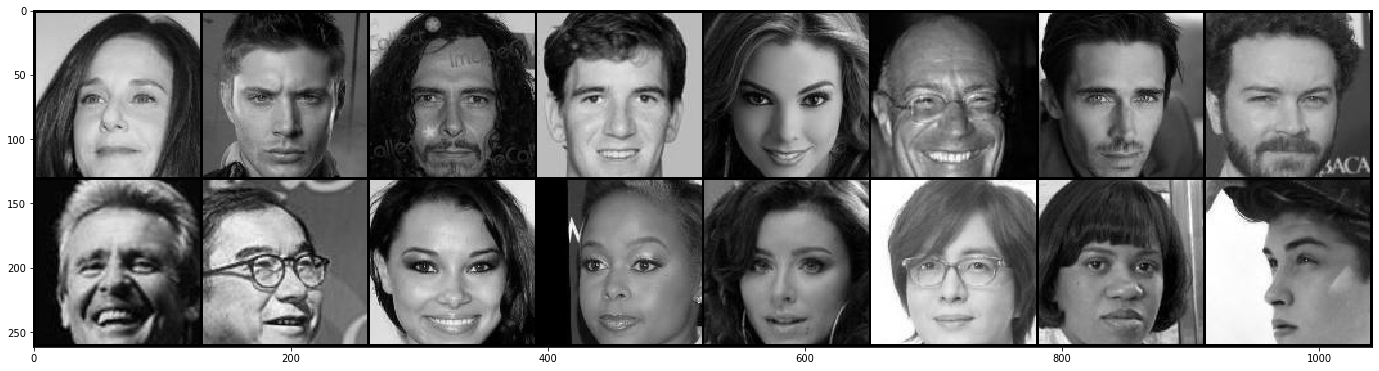

In [452]:
grid = torchvision.utils.make_grid(x, nrow=8)
x, y = next(iter(train_loader))
plt.figure(figsize=(24, 8))
plt.imshow(grid.permute(1, 2, 0), cmap="gray");

### 2. Model

In [453]:
# model params
IN_CHANNELS = 1
OUT_CHANNELS = 1
Z_DIM = 8 # if z_dim = 8 the size of Z will be 8*8 = 64

In [649]:
class VAE(nn.Module):
    
    def __init__(self, 
                 in_channels=1,
                 hidden_dims=None,
                 latent_dim=8, 
                 im_height=128, 
                 im_width=128, 
                 out_channels=1):
        
        super(VAE, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.latent_dim = latent_dim
        
        
        
        # shrinking path -> encoder modules
        if hidden_dims is None:
            hidden_dims = [16, 32, 64, 128, 256, 512]
        encoder_modules = [] 
        for dim in hidden_dims:
            encoder_modules.append(self.conv_block(in_channels=in_channels, out_channels=dim, norm_dim=dim))
            in_channels = dim
        self.encoder = nn.Sequential(*encoder_modules)    
        
        # expansive path -> decoder modules
        self.deconv = self.deconv_block(in_channels=1, out_channels=1)
        
        
    def conv_block(self, in_channels, out_channels, norm_dim):
        # conv layer followed by BatchNorm and Leaky Relu to downsample the image
        conv = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(norm_dim),
                nn.LeakyReLU()
        )
        return conv
    
    # probablistic encoder
    def encoder_block(self, x):
        # x.size() -> [batch_size, channel, height, width]
        # initial input has 1 channel (gray scale image)
        x1 = self.encoder(x)
        flatten = nn.Flatten()(x1)
        mu = nn.Linear(in_features=flatten.size(1), out_features=self.latent_dim)(flatten)
        var = nn.Linear(in_features=flatten.size(1), out_features=self.latent_dim)(flatten)
        return mu, var
        
    def reparametrize(self, mu, var):
        std = torch.exp(0.5*var)
        esp = torch.rand_like(std)
        return esp*std + mu
    
    
    # probablistic decoder
    def decoder(self, z):
        # z.size() -> [batch_size, features]
        x = z.view(-1, 1, self.latent_dim, self.latent_dim)   # Channelize the Z, remember when we used z_dim as sqrt of Z.size(0)
        out = self.deconv(x)
        return out
    
    def deconv_block(self, in_channels, out_channels):
        # single deconv layer followed by a Tanh activation to upsample the image
        deconv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=2, padding=0),
            nn.Sigmoid(),
        )
        return deconv
    
    def forward(self, x):
        mu, var = self.encoder_block(x)
        # re-parametrization
        out = self.reparametrize(mu, var)
        
        return out
        

### 3. Training

In [455]:
import torch.utils.tensorboard as tensorboard

In [456]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
lr = 1e-3
writer = tensorboard.SummaryWriter()

In [491]:
# create the model and ship it on GPU
model = VAE().to(device)

NameError: name 'z_dim' is not defined

In [458]:
# loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

In [477]:
epochs = 10
steps = 0

epoch_progress = tqdm(total=epochs, desc="Epoch", position=0)

for epoch in range(epochs):
    
    step_progress = tqdm(total=len(train_loader), desc="Steps", position=0)
    epoch_loss = []
    
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        
        outputs, mu, sigma = model(images)
        
        # Loss = Reconstruction_Loss + Kl_Div
        reconstruction_loss = torch.nn.functional.mse_loss(outputs.view(-1, 128*128), images.view(-1, 128*128))
        kl_div = 0.5 * torch.sum(torch.exp(sigma) + mu**2 - 1.0 - sigma)
        loss = reconstruction_loss + kl_div
        
        
        # Backpropagate the Loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if steps%50==0:
            print(f'Epoch {epoch} | Step {steps} | Loss {loss.item()}')
        
        epoch_loss.append(loss.item())
        writer.add_scalar("Step Loss", loss.item(), steps)
        
        steps += 1
        step_progress.update(1)
        
    avg_loss = sum(epoch_loss)/len(epoch_loss)
    print(f'Epoch {epoch} | Loss = {avg_loss}')
    writer.add_scalar("Loss", avg_loss, epoch)
    epoch_progress.update(1)

Steps:   1%|          | 1/156 [00:00<00:41,  3.70it/s]

Epoch 0 | Step 0 | Loss 16.54241943359375


Steps:  33%|███▎      | 51/156 [00:12<00:27,  3.83it/s]

Epoch 0 | Step 50 | Loss 14.308341026306152


Steps:  65%|██████▍   | 101/156 [00:26<00:14,  3.78it/s]

Epoch 0 | Step 100 | Loss 13.170780181884766


Steps:  97%|█████████▋| 151/156 [00:39<00:01,  3.75it/s]

Epoch 0 | Step 150 | Loss 15.245843887329102


Steps:   0%|          | 0/156 [00:00<?, ?it/s]55s/it]/s]

Epoch 0 | Loss = 15.944714075479752


Steps:  29%|██▉       | 45/156 [00:11<00:28,  3.94it/s]

Epoch 1 | Step 200 | Loss 13.045809745788574


Steps:  61%|██████    | 95/156 [00:24<00:15,  3.89it/s]

Epoch 1 | Step 250 | Loss 15.786873817443848


Steps:  93%|█████████▎| 145/156 [00:37<00:02,  3.95it/s]

Epoch 1 | Step 300 | Loss 17.312522888183594


Steps:   0%|          | 0/156 [00:00<?, ?it/s]37s/it]/s]

Epoch 1 | Loss = 16.058659020142677


Steps:  25%|██▌       | 39/156 [00:10<00:31,  3.77it/s]

Epoch 2 | Step 350 | Loss 14.217609405517578


Steps:  57%|█████▋    | 89/156 [00:23<00:17,  3.82it/s]

Epoch 2 | Step 400 | Loss 16.653732299804688


Steps:  89%|████████▉ | 139/156 [00:36<00:04,  3.74it/s]

Epoch 2 | Step 450 | Loss 17.755529403686523


Steps:   0%|          | 0/156 [00:00<?, ?it/s]44s/it]/s]

Epoch 2 | Loss = 16.06548030865498


Steps:  21%|██        | 33/156 [00:08<00:33,  3.64it/s]

Epoch 3 | Step 500 | Loss 16.53877830505371


Steps:  53%|█████▎    | 83/156 [00:22<00:20,  3.53it/s]

Epoch 3 | Step 550 | Loss 15.80833625793457


Steps:  85%|████████▌ | 133/156 [00:35<00:05,  3.84it/s]

Epoch 3 | Step 600 | Loss 14.695833206176758


Steps:   0%|          | 0/156 [00:00<?, ?it/s]89s/it]/s]

Epoch 3 | Loss = 15.871642369490404


Steps:  17%|█▋        | 27/156 [00:07<00:34,  3.77it/s]

Epoch 4 | Step 650 | Loss 16.201738357543945


Steps:  49%|████▉     | 77/156 [00:20<00:21,  3.72it/s]

Epoch 4 | Step 700 | Loss 15.743971824645996


Steps:  81%|████████▏ | 127/156 [00:33<00:07,  3.92it/s]

Epoch 4 | Step 750 | Loss 15.188748359680176


Steps:   0%|          | 0/156 [00:00<?, ?it/s]89s/it]/s]

Epoch 4 | Loss = 15.848170764935322


Steps:  13%|█▎        | 21/156 [00:05<00:34,  3.92it/s]

Epoch 5 | Step 800 | Loss 16.537796020507812


Steps:  46%|████▌     | 71/156 [00:18<00:23,  3.64it/s]

Epoch 5 | Step 850 | Loss 15.883445739746094


Steps:  78%|███████▊  | 121/156 [00:32<00:08,  4.09it/s]

Epoch 5 | Step 900 | Loss 16.98326301574707


Steps:   0%|          | 0/156 [00:00<?, ?it/s]04s/it]/s]

Epoch 5 | Loss = 15.883303069151365


Steps:  10%|▉         | 15/156 [00:03<00:34,  4.09it/s]

Epoch 6 | Step 950 | Loss 16.600988388061523


Steps:  42%|████▏     | 65/156 [00:16<00:23,  3.88it/s]

Epoch 6 | Step 1000 | Loss 17.110271453857422


Steps:  74%|███████▎  | 115/156 [00:28<00:09,  4.20it/s]

Epoch 6 | Step 1050 | Loss 15.498491287231445


Steps:   0%|          | 0/156 [00:00<?, ?it/s]20s/it]/s]

Epoch 6 | Loss = 16.036230246225994


Steps:   6%|▌         | 9/156 [00:02<00:35,  4.19it/s]

Epoch 7 | Step 1100 | Loss 16.927526473999023


Steps:  38%|███▊      | 59/156 [00:14<00:24,  3.98it/s]

Epoch 7 | Step 1150 | Loss 14.711289405822754


Steps:  70%|██████▉   | 109/156 [00:27<00:11,  4.25it/s]

Epoch 7 | Step 1200 | Loss 15.157526969909668


Steps:   0%|          | 0/156 [00:00<?, ?it/s]81s/it]/s]

Epoch 7 | Loss = 15.852883791312193


Steps:   2%|▏         | 3/156 [00:00<00:41,  3.69it/s]

Epoch 8 | Step 1250 | Loss 15.869094848632812


Steps:  34%|███▍      | 53/156 [00:13<00:26,  3.84it/s]

Epoch 8 | Step 1300 | Loss 18.18783187866211


Steps:  66%|██████▌   | 103/156 [00:27<00:14,  3.61it/s]

Epoch 8 | Step 1350 | Loss 14.959553718566895


Steps:  98%|█████████▊| 153/156 [00:40<00:00,  3.88it/s]

Epoch 8 | Step 1400 | Loss 15.111400604248047


Steps:   0%|          | 0/156 [00:00<?, ?it/s]09s/it]/s]

Epoch 8 | Loss = 16.031311492125194


Steps:  30%|███       | 47/156 [00:12<00:30,  3.52it/s]

Epoch 9 | Step 1450 | Loss 15.200899124145508


Steps:  62%|██████▏   | 97/156 [00:26<00:16,  3.68it/s]

Epoch 9 | Step 1500 | Loss 17.152969360351562


Steps:  94%|█████████▍| 147/156 [00:39<00:02,  3.77it/s]

Epoch 9 | Step 1550 | Loss 16.659320831298828


Epoch: 100%|██████████| 10/10 [06:45<00:00, 40.65s/it]s]

Epoch 9 | Loss = 16.044589441556198


In [650]:
model = VAE(latent_dim=64)

In [651]:
inp = torch.randn(1, 1, 128, 128) #x[1].view(1, 1, 128, 128)

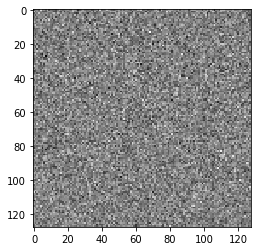

In [652]:
plt.imshow(inp.view(128, 128), cmap="gray");

In [653]:
inp.size()

torch.Size([1, 1, 128, 128])

In [654]:
out = model(inp)

In [656]:
print(out.size())

torch.Size([1, 64])


In [610]:
print(out.size(), mu.size(), sigma.size())

AttributeError: 'tuple' object has no attribute 'size'

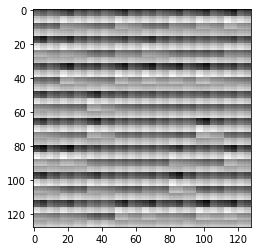

In [483]:
plt.imshow(out.detach().view(128, 128), cmap="gray")

In [484]:
print(inp.size(), out.size())

torch.Size([1, 1, 128, 128]) torch.Size([1, 1, 128, 128])


In [485]:
recons = torch.nn.functional.binary_cross_entropy(out.view(-1, 128*128), inp.view(-1, 128*128)).item()

In [486]:
kl_div = 0.5 * torch.sum(torch.exp(sigma) + mu**2 - 1.0 - sigma)

In [488]:
(recons + kl_div)*64

tensor(49.0337, grad_fn=<MulBackward0>)